Provable *Polytope* Repair of MNIST DNNs
========================================

In [1]:
# !pip install -r requirements.txt --index-url https://download.pytorch.org/whl/cu113
import warnings; warnings.filterwarnings("ignore")
import os, sys; sys.path.insert(0, os.getcwd())
import torch

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float64

### Load a MNIST pytorch model

In [2]:
from experiments import mnist
model = mnist.model('9x100').to(device,dtype).eval()

### Construct repair set from the MNIST-C dataset.

image_polytopes (1, 7, 784): 1 polytope(s) of 7 vertices.
Expected labels: tensor([8, 8, 8, 8, 8, 8, 8])
Misclassified as: tensor([5, 5, 5, 5, 5, 8, 8])


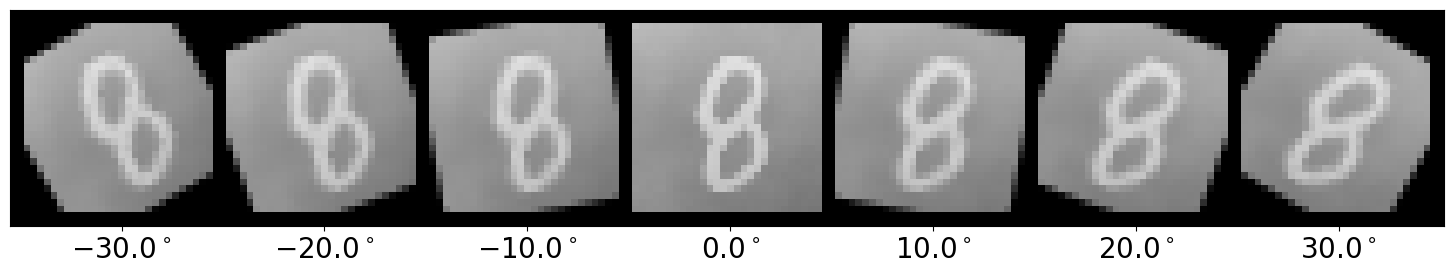

In [3]:
from experiments import mnist
import numpy as np

# Load the MNIST-C dataset.
mnist_c = mnist.datasets.MNIST_C(corruption='fog', split='test').reshape(784).to(device,dtype)

# Find all misclassified images from MNIST-C with label `8`.
_, misclassified_dataset = mnist_c.filter_label(8).misclassified(model)

# Construct the polytope repair set by rotate each misclassified image with [-30, -20, -10, 0, 10, 20, 30] degrees.
# An input polytope is represented as its seven vertices of the rotated images.
rotation_dataset = misclassified_dataset.rotate(degs=np.linspace(-30., 30., 7), scale=1.).to(device,dtype)

# Check an input polytope.
image_polytopes, labels = rotation_dataset.load(1)
print(f"image_polytopes {tuple(image_polytopes.shape)}: {image_polytopes.shape[0]} polytope(s) of {image_polytopes.shape[1]} vertices.")
print("Expected labels:", labels.flatten().long())
print("Misclassified as:", model(image_polytopes[0].to(device,dtype)).argmax(-1).cpu())
mnist.imshow(image_polytopes, degs=rotation_dataset.degs)

##

In [4]:
import sytorch as st

image_polytopes = image_polytopes.to(device,dtype)

# We use an the Gurobi LP solver as the optimizer.
optimizer = st.GurobiSolver().verbose_()

# Attach the model to the optimizer
model.to(optimizer)

# Make the first layer weight and all-layer bias editable.
model.requires_symbolic_weight_and_bias()

# Toggle the symbolic-execution mode.
model.repair()

# Encode the symbolic output vpolytope, such that all vertices are in the same linear region.
symbolic_output_vpolytopes = model.v(image_polytopes)

# Prepare objectives: parameter detla.
param_delta = model.parameter_deltas()

# Prepare objectives: output delta.
with st.no_symbolic():
    original_output_vpolytopes = model.v(image_polytopes)
output_delta = (symbolic_output_vpolytopes - original_output_vpolytopes).reshape(-1)

delta = param_delta.norm_ub('linf+l1_normalized') + output_delta.norm_ub('linf+l1_normalized')

# Find optimal parameters that satisfies the repair specification.
assert optimizer.solve(
    # Add the output constraint.
    symbolic_output_vpolytopes.argmax(-1) == labels, 
    
    # Specify the minimization objective.
    minimize=delta
)

# Update the model with the optimal parameters that satisfies the repair specification.
repaired_model = model.update_().eval()


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-28
Set parameter Crossover to value 0
Set parameter Method to value 2
Set parameter Threads to value 32
Set parameter Presolve to value 1


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.2 LTS")

CPU model: Intel(R) Core(TM) i9-9960X CPU @ 3.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 339725 rows, 249114 columns and 2144040 nonzeros
Model fingerprint: 0x8348704d
Coefficient statistics:
  Matrix range     [6e-06, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-06, 6e-01]
Presolve removed 241042 rows and 86352 columns
Presolve time: 0.93s
Presolved: 98683 rows, 162762 columns, 1657406 nonzeros
Ordering time: 1.28s

Barrier statistics:
 Dense cols : 1
 Free vars  : 8701
 AA' NZ     : 1.695e+06
 Factor NZ  : 1.004e+07 (roughly 200 MB of memory)
 Factor Ops : 9.618e+09 (less than 1 second per iteration)
 Threads    : 32

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0 

### Evaluate efficacy of the  repaired model

image_polytopes (1, 7, 784): 1 polytope(s) of 7 vertices.
Expected labels: tensor([8, 8, 8, 8, 8, 8, 8])
Prediction after repair: tensor([8, 8, 8, 8, 8, 8, 8])


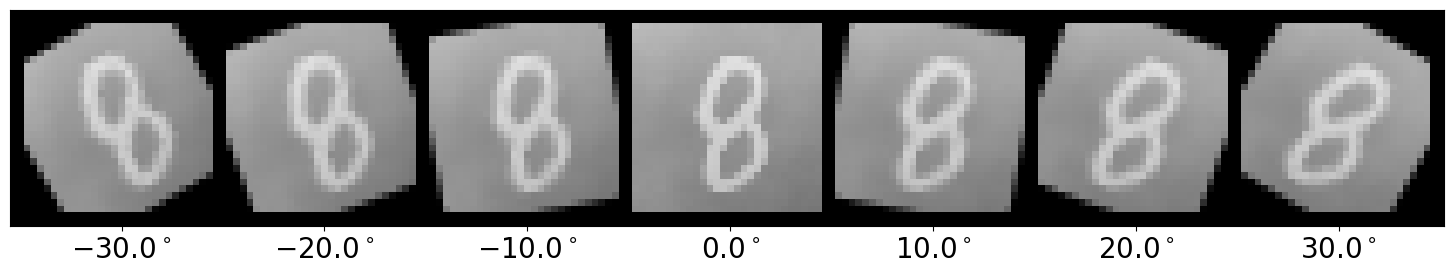

In [5]:
image_polytopes, labels = rotation_dataset.load(1)
print(f"image_polytopes {tuple(image_polytopes.shape)}: {image_polytopes.shape[0]} polytope(s) of {image_polytopes.shape[1]} vertices.")
print("Expected labels:", labels.flatten().long())
print("Prediction after repair:", repaired_model(image_polytopes[0].to(device,dtype)).argmax(-1).cpu())
mnist.imshow(image_polytopes, degs=rotation_dataset.degs)

### Evaluate accuracy of the  repaired model

In [6]:
testset = mnist.datasets.Dataset('identity', 'test').reshape(784).to(device,dtype)

original_model = mnist.model('9x100').to(device,dtype).eval()
acc0 = testset.accuracy(original_model)
acc1 = testset.accuracy(repaired_model)
drawdown = acc0 - acc1
print(f"APRNN Drawdown: {acc0:.2%} -> {acc1:.2%} ({'+' if drawdown > 0 else ''}{drawdown:.2%}).")


APRNN Drawdown: 95.08% -> 95.23% (-0.15%).
